In [1]:
# Short-term dynamics of Excitation-Inhibition Balance in Hippocampal CA3-CA1 circuit
# Aditya Asopa, Upinder Singh Bhalla, NCBS
# Figure 2
# September 2024
# Imports -----------------------------------------------------------------------------------------------
from   pathlib      import Path
import importlib

import numpy                as np
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import seaborn              as sns
import pandas               as pd

from scipy.stats   import kruskal, wilcoxon, mannwhitneyu, ranksums
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
import statsmodels.formula.api as smf

# from eidynamics     import utils, data_quality_checks, ephys_classes, plot_tools, expt_to_dataframe
# from eidynamics     import pattern_index
# from eidynamics     import abf_to_data
from eidynamics.fit_PSC     import find_sweep_expected
# from Findsim        import tab_presyn_patterns_LR_43
# import parse_data
from eidynamics     import utils, plot_tools
import all_cells
import plotFig2
import stat_annotate

# sns.set_context('paper')
# sns.set_context('paper')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# make a colour map viridis
viridis = mpl.colormaps["viridis"]
flare   = mpl.colormaps["flare"]
crest   = mpl.colormaps["crest"]
magma   = mpl.colormaps["magma"]
edge    = mpl.colormaps['edge']

color_E = "flare"
color_I = "crest"
color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
color_squares = color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
color_EI = {-70:flare(0), 0:crest(0)}
colors_EI = {-70:flare, 0:crest}

Fs = 2e4
%matplotlib widget
freq_sweep_pulses = np.arange(9)

>> Working on:  C:\Users\adity\OneDrive\NCBS


In [2]:
figure_raw_material_location = Path(r"paper_figure_matter\\")
paper_figure_export_location = Path(r"paper_figures\\Figure2v4\\")
data_path_FS                 = Path(r"parsed_data\\FreqSweep\\")
data_path_grid               = Path(r"parsed_data\\Grid\\")
data_path_analysed           = Path(r"parsed_data\\second_order\\")
raw_data_path_cellwise       = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\Screened_cells\\")

In [3]:
# September 2024
# short data path that contains the kernel fit data for FreqSweep protocol, also contains the field p2p data. latest and checked. Use this for all freqsweep measurements.
# Contains screening parameters also.
# 18Sep24
CC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_CC_kernelfit_response_measurements.h5"
cc_FS_shortdf = pd.read_hdf(CC_FS_shortdf_withkernelfit_datapath, key='data')
print(cc_FS_shortdf.shape)

VC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_VC_kernelfit_response_measurements.h5"
vc_FS_shortdf = pd.read_hdf(VC_FS_shortdf_withkernelfit_datapath, key='data')
print(vc_FS_shortdf.shape)

# short data path for all protocols.
# Does not contain kernel fit measurements and does not contain screening parameters. Only use for other protocols.
# 18Sep24
dfshortpath     = data_path_analysed / "all_cells_allprotocols_with_fpr_values.h5"
xc_all_shortdf  = pd.read_hdf(dfshortpath, key='data')
print(xc_all_shortdf.shape)

# Load the long dataset
cc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_CC_long.h5" 
vc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_VC_long.h5"

(4971, 163)
(4113, 163)
(16870, 63)


In [4]:
# CC data screening based on dataflag_fields
cc_FS_shortdf_slice = cc_FS_shortdf[
            (cc_FS_shortdf['location'] == 'CA1') &
            (cc_FS_shortdf['numSq'].isin([1,5,15])) &
            (cc_FS_shortdf['stimFreq'].isin([20,30,40,50])) &
            (cc_FS_shortdf['condition'] == 'Control') &
            (cc_FS_shortdf['ch0_response']==1) &
            (cc_FS_shortdf['intensity'] == 100) &
            (cc_FS_shortdf['pulseWidth'] == 2) &
            (cc_FS_shortdf['probePulseStart'] == 0.2) &
            (cc_FS_shortdf['IR'] >50) & (cc_FS_shortdf['IR'] < 300) &
            (cc_FS_shortdf['tau'] < 40) & 
            (cc_FS_shortdf['ac_noise_power_in_ch0'] < 40) &
            (cc_FS_shortdf['spike_in_baseline_period'] == 0) &
            (cc_FS_shortdf['sweepBaseline'] > -100) & (cc_FS_shortdf['sweepBaseline'] < 100)&
            # valley_0 should notbe nan
            (cc_FS_shortdf['valley_0'].notnull())
        ]
print(cc_FS_shortdf.shape, '--screened-->', cc_FS_shortdf_slice.shape)
screened_cc_trialIDs = cc_FS_shortdf_slice['trialID'].unique()

print(f"Unique cells in screened data: { cc_FS_shortdf_slice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {cc_FS_shortdf_slice['trialID'].nunique()}")

# save trial IDs as a numpy array text file, all trialID are strings
np.savetxt(data_path_FS / "Figure2_screened_trialIDs_CC_FS.txt", screened_cc_trialIDs, fmt='%s')

(4971, 163) --screened--> (588, 163)
Unique cells in screened data: 4
Unique sweeps in screened data: 588


In [5]:
# VC data screening based on dataflag_fields
vc_FS_shortdf_slice = vc_FS_shortdf[
            (vc_FS_shortdf['location'] == 'CA1') &
            (vc_FS_shortdf['numSq'].isin([1,5,15])) &
            (vc_FS_shortdf['stimFreq'].isin([20,30,40,50])) &
            (vc_FS_shortdf['condition'] == 'Control') &
            (vc_FS_shortdf['ch0_response']==1) &
            (vc_FS_shortdf['intensity'] == 100) &
            (vc_FS_shortdf['pulseWidth'] == 2) &
            (vc_FS_shortdf['probePulseStart']==0.2) &
            (vc_FS_shortdf['IR'] >50) & (vc_FS_shortdf['IR'] < 300) &
            (vc_FS_shortdf['tau'] < 40) & 
            (vc_FS_shortdf['ac_noise_power_in_ch0'] < 40)&
            (vc_FS_shortdf['valley_0'].notnull())
        ]
print(vc_FS_shortdf.shape, '--screened-->', vc_FS_shortdf_slice.shape)
screened_vc_trialIDs = vc_FS_shortdf_slice['trialID'].unique()

print(f"Unique cells in screened data: { vc_FS_shortdf_slice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {vc_FS_shortdf_slice['trialID'].nunique()}")

# save the screened trialIDs
# save trial IDs as a numpy array text file, all trialID are strings
np.savetxt(data_path_FS / "Figure2_screened_trialIDs_VC_FS.txt", screened_vc_trialIDs, fmt='%s')

(4113, 163) --screened--> (931, 163)
Unique cells in screened data: 6
Unique sweeps in screened data: 931


In [6]:
# combine short dataframes slice and delete the original ones
xc_FS_shortdf_slice = pd.concat([cc_FS_shortdf_slice, vc_FS_shortdf_slice], axis=0)
del cc_FS_shortdf, vc_FS_shortdf
del cc_FS_shortdf_slice, vc_FS_shortdf_slice

In [7]:
### Load the Longform data and keep the screened trials only to save space
# load the data
cc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_CC_long.h5"
cc_FS_longdf = pd.read_hdf(cc_FS_datapath, key='data')

cc_FS_longdf_slice = cc_FS_longdf[ cc_FS_longdf['trialID'].isin(screened_cc_trialIDs) ]
print('CC: ', cc_FS_longdf.shape, '--screened-->', cc_FS_longdf_slice.shape)
del cc_FS_longdf

# load the data
vc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_VC_long.h5"
vc_FS_longdf = pd.read_hdf(vc_FS_datapath, key='data')

vc_FS_longdf_slice = vc_FS_longdf[ vc_FS_longdf['trialID'].isin(screened_vc_trialIDs) ]
print('VC: ', vc_FS_longdf.shape, '--screened-->', vc_FS_longdf_slice.shape)
del vc_FS_longdf

xc_FS_longdf_slice = pd.concat([cc_FS_longdf_slice, vc_FS_longdf_slice])
del cc_FS_longdf_slice, vc_FS_longdf_slice

CC:  (4971, 80073) --screened--> (588, 80073)
VC:  (4407, 80073) --screened--> (931, 80073)


## function for Heatmap plotting

## Current clamp normalised responses (peak to valley) for all screened cells

### normalized PSP

data shape: (538, 163)
[4041 3611 3131 5611]
0 0 1 -70 (3303, 7)
1 0 5 -70 (1035, 7)
2 0 15 -70 (504, 7)


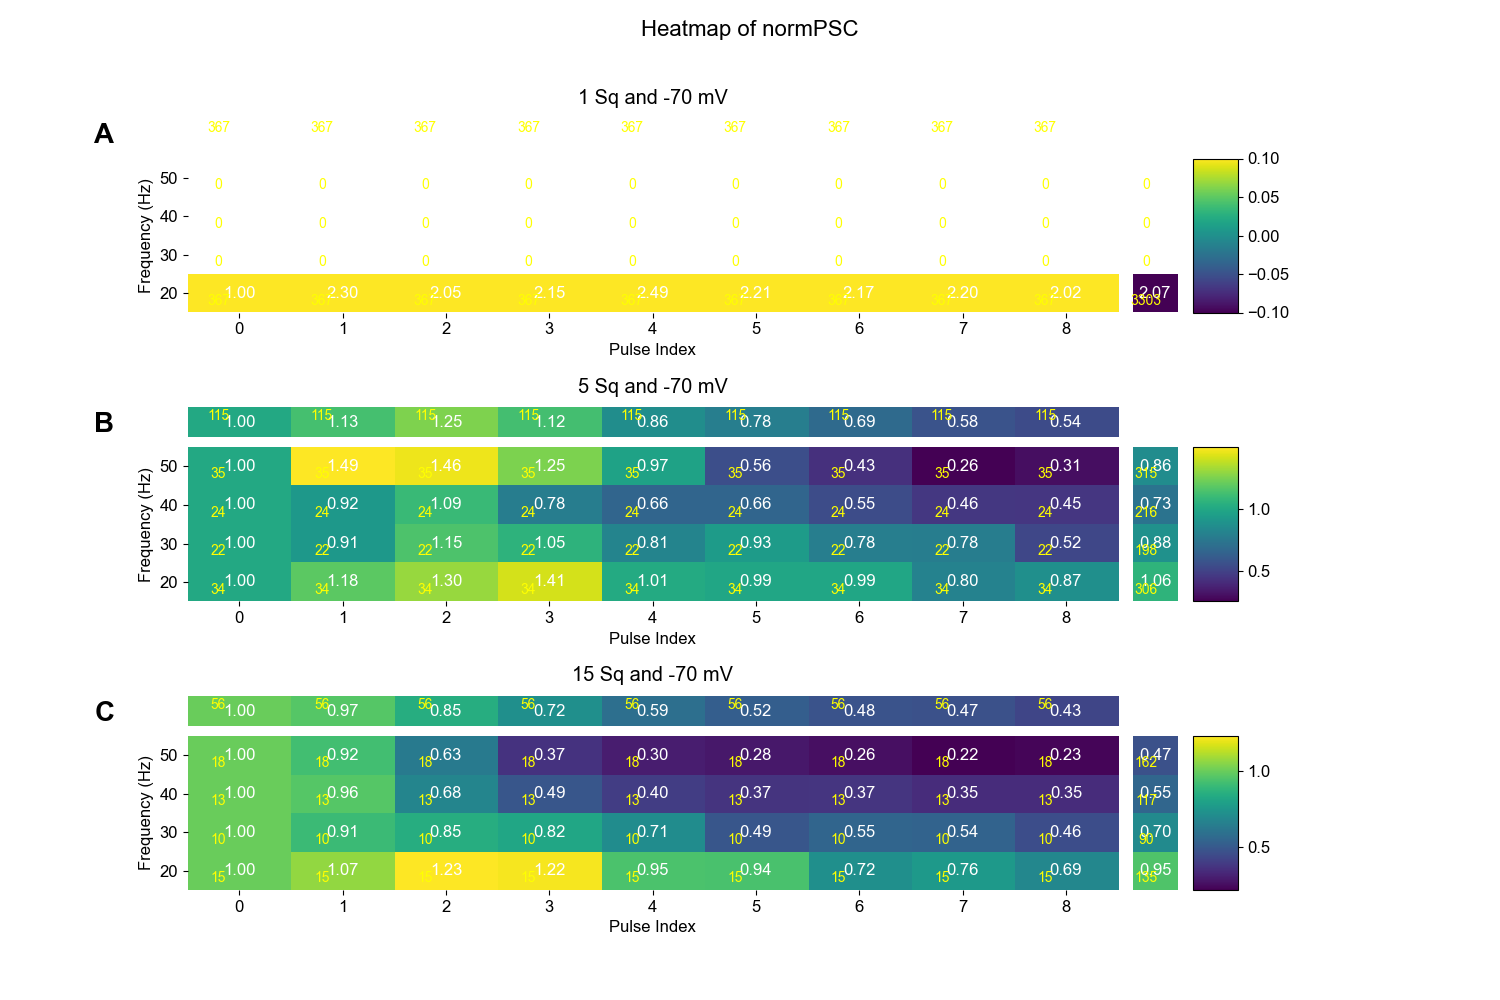

In [10]:
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='CC')]
fig2A, axes2A = plot_tools.plot_response_heatmaps(dftemp[dftemp['AP']==0], feature='normPSC_', figname_suffix="CC", clampMode='CC', annot=True)

## Spike count/likelihood

C:\Users\adity\AppData\Local\Temp\ipykernel_90560\2666230826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp['numspikes'] = dftemp[[f'spike_{i}' for i in range(9)]].sum(axis=1)


(39, 164)
data shape: (39, 164)
[3611 3131]
0 0 5 -70 (180, 7)
1 0 15 -70 (171, 7)


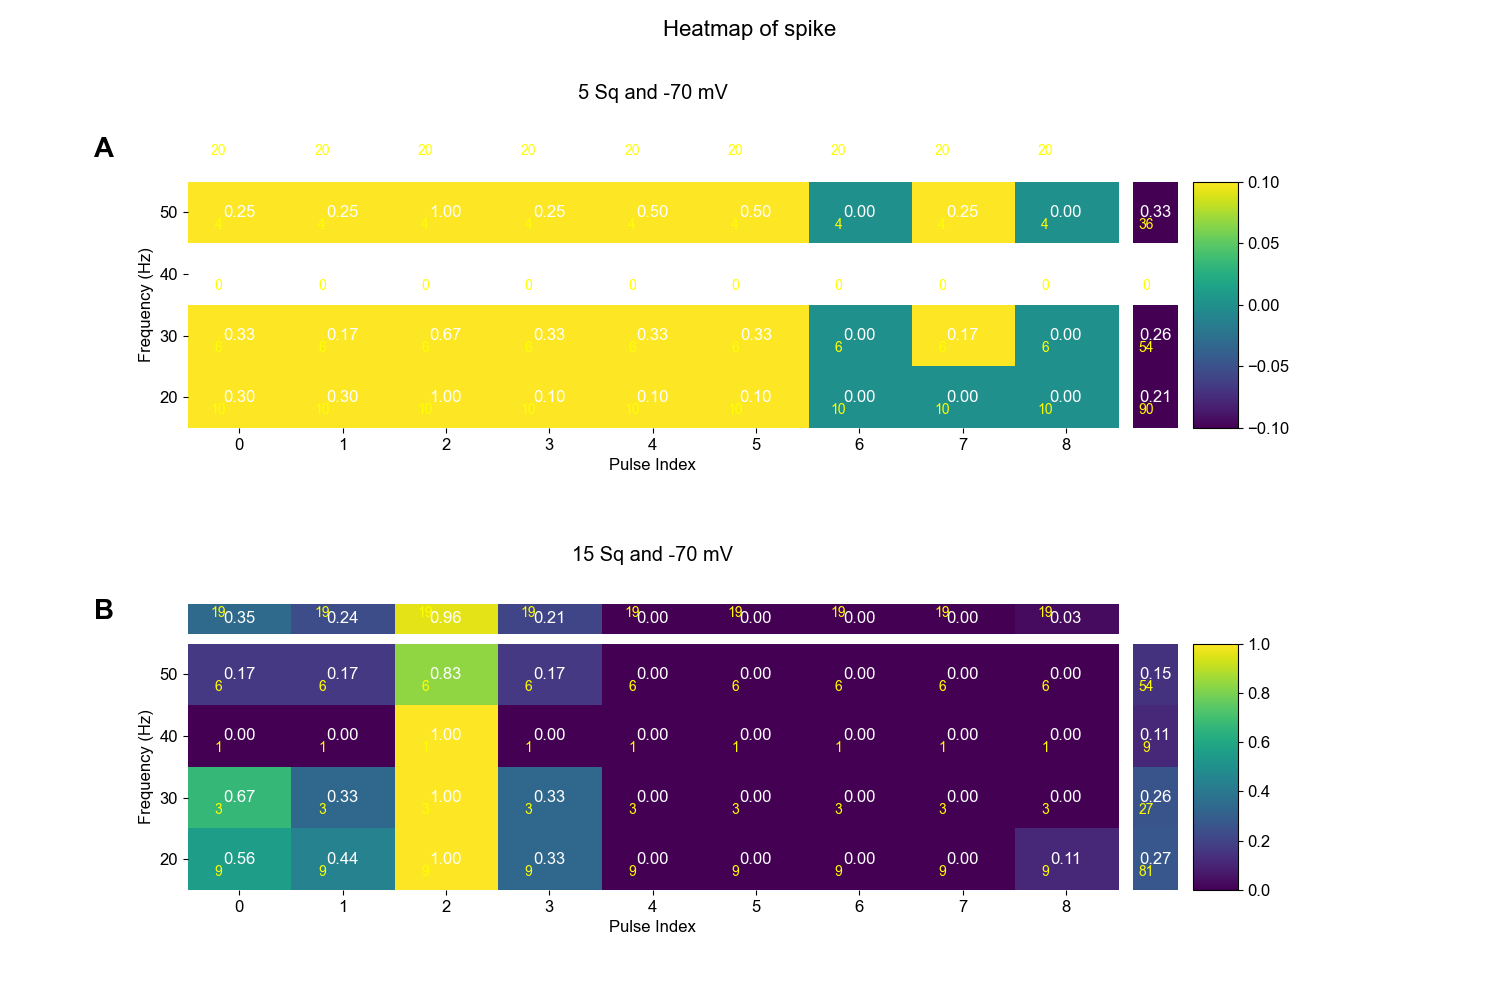

No such comm: 967ea5b5d1ee4fcca01d02cc2e4133ef


In [11]:
# if the sum of spike_0 to spike_8 is greater than 4, then dont take that trial
dftemp=xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='CC')]
dftemp['numspikes'] = dftemp[[f'spike_{i}' for i in range(9)]].sum(axis=1)
dftemp= dftemp[(dftemp['AP']==1) & (dftemp['numspikes'] < 5)]
print(dftemp.shape)
axesCC2 = plot_response_heatmaps(dftemp, feature='spike_', figname_suffix="1-4spikes_CC", clampMode='CC', annot=True)

# Plot EPSCs and IPSCs as heatmaps

In [12]:
dftemp=xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='VC')]
print(dftemp.shape)

(931, 163)


## normalised PSCs

data shape: (931, 163)
[1531 1621  111 7492 6201 6301]
0 0 1 -70 (1206, 7)
0 1 1 0 (1476, 7)
1 0 5 -70 (2214, 7)
1 1 5 0 (1323, 7)
2 0 15 -70 (1341, 7)
2 1 15 0 (819, 7)


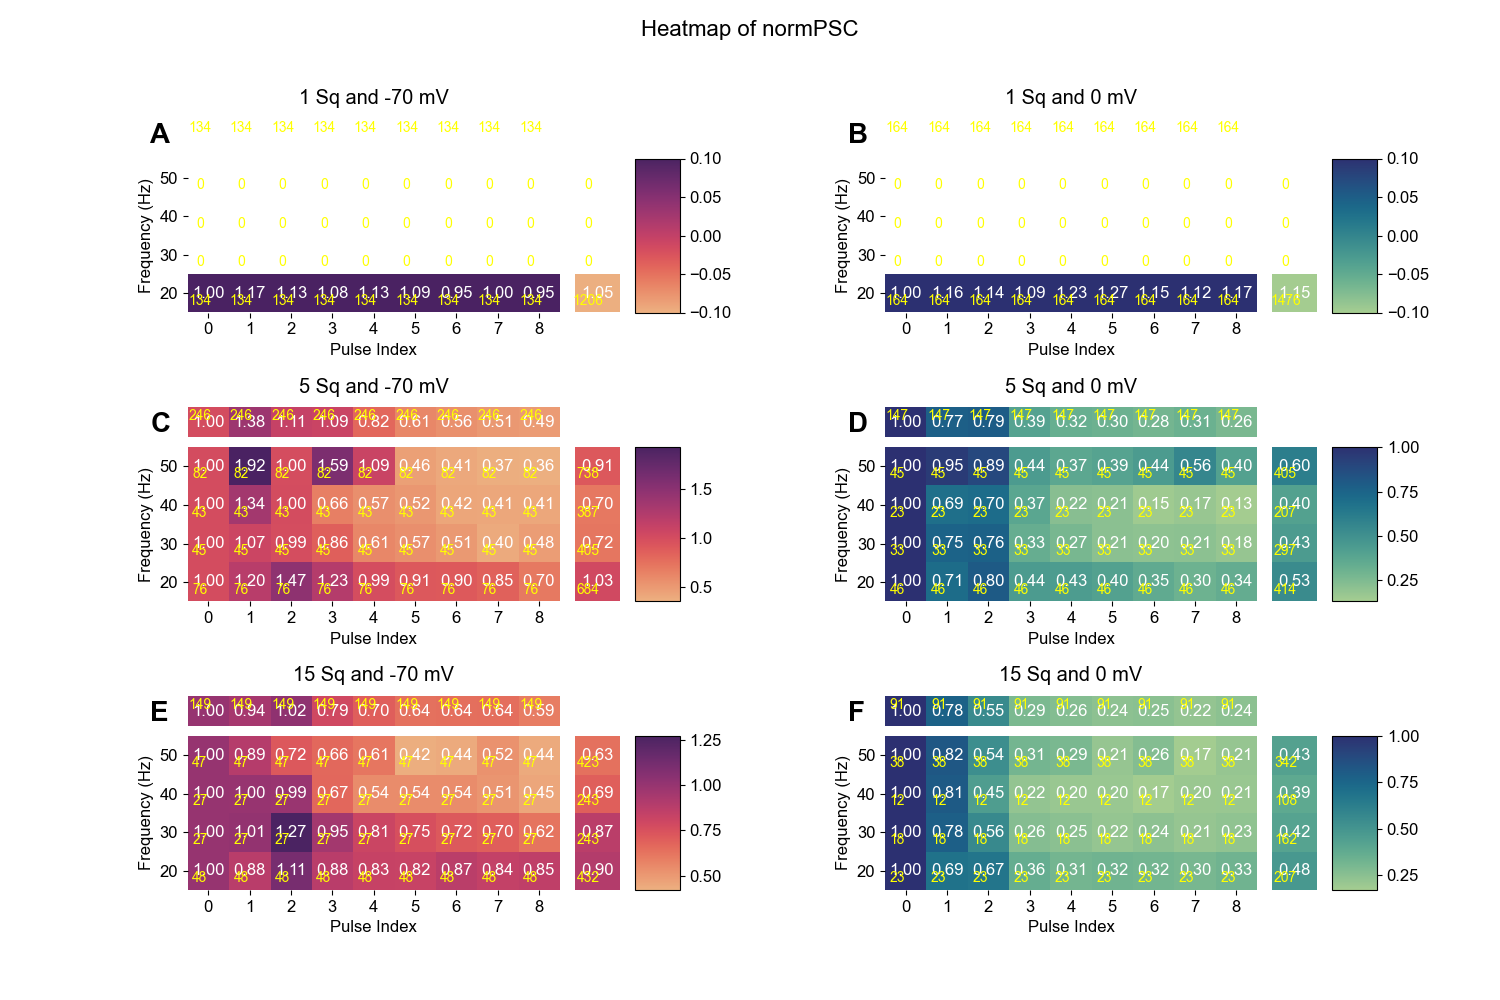

No such comm: 122db3c25f664ec296e2b3b11307d463


In [13]:
axesVC1 = plot_response_heatmaps(dftemp, feature='normPSC_', figname_suffix="VC", clampMode='VC', annot=True)

In [ ]:
paper_figure_export_location = Path(r"paper_figures\\Figure2v4\\stats\\"

## ANOVA

In [14]:
from statsmodels.formula.api import ols

def anova_on_data(df, feature, exclude_from_model=["patternList"], categorical=['cellID'], only_max_pulse=False):
    idvars=['cellID','clampPotential','stimFreq','numSq','patternList']
    to_plot = [f'{feature}_{i}' for i in range(9)]
    df_melt = pd.melt( df, id_vars=idvars, value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
    if not 'pulse' in df.columns:
        df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
        df_melt['pulse'] = df_melt['pulse'].astype(int)
        df_melt.drop(columns=['pulseIndex'], inplace=True)

    # add 'pulse' to idvars
    idvars.append('pulse')

    if only_max_pulse:
        # for every cellID, stimFreq, clampPotential, numSq, patternList and pulse, assign a trial
        df_melt['trial'] = df_melt.groupby(idvars).cumcount()

        # for every cellID, stimFreq, clampPotential, numSq, patternList, and trial combination, find out which pulse has the highest peak_response value
        # Group by the specified columns and find the index of the maximum peak_response within each group
        groupby_idvars = ['cellID','clampPotential', 'stimFreq','numSq', 'patternList','trial']
        idx = df_melt.groupby(groupby_idvars)['peak_response'].idxmax()
        # Use the index to select the corresponding rows
        df_melt = df_melt.loc[idx].reset_index(drop=True)
        print(df_melt.shape)
    
    # build model
    # convert idvars to model string
    model_params = []
    for var in idvars:
        if var in exclude_from_model:
            continue
        if var in categorical:
            model_params.append(f'C({var})')
        else:
            model_params.append(f'{var}')
    model_params = '+'.join(model_params)

    model_string = f'peak_response ~ {model_params}'
    model = ols(model_string, data=df_melt).fit() # CC data
    # Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(df_melt.shape)
    print('\n',model_string, '\n', anova_table)

## 1. CC data

In [15]:
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='CC') & (xc_FS_shortdf_slice['AP']==0)]

dftemp['numSq'].astype(int)
dftemp['clampPotential'].astype(int)
dftemp['stimFreq'].astype(int)
# convert patternList to integer
dftemp['patternList'].apply(lambda x: int(x))

print(dftemp.shape)

(538, 163)


### 1.1 ANOVA with all peak responses

In [16]:
anova_on_data(dftemp, 'PSC', exclude_from_model=["clampPotential","patternList"], categorical=['cellID'])
anova_on_data(dftemp, 'normPSC', exclude_from_model=["clampPotential","patternList"], categorical=['cellID'])

(4842, 7)

 peak_response ~ C(cellID)+stimFreq+numSq+pulse 
                 sum_sq      df            F        PR(>F)
C(cellID)  2966.582990     3.0  1528.104795  0.000000e+00
numSq      2048.380848     2.0  1582.699998  0.000000e+00
stimFreq    122.357578     1.0   189.081379  3.117557e-42
pulse       291.399029     1.0   450.304194  1.262331e-95
Residual   3128.158535  4834.0          NaN           NaN
(4842, 7)

 peak_response ~ C(cellID)+stimFreq+numSq+pulse 
                   sum_sq      df         F    PR(>F)
C(cellID)     701.748120     3.0  5.761396  0.000626
numSq         329.211420     2.0  4.054270  0.017407
stimFreq        0.315054     1.0  0.007760  0.929809
pulse           1.500355     1.0  0.036954  0.847567
Residual   196263.219116  4834.0       NaN       NaN


### 1.2 Only pulses that causes highest response in a given trial

In [17]:
anova_on_data(dftemp, 'PSC', exclude_from_model=["clampPotential","patternList"], categorical=['cellID'], only_max_pulse=True)
anova_on_data(dftemp, 'normPSC', exclude_from_model=["clampPotential","patternList"], categorical=['cellID'], only_max_pulse=True)

(538, 8)
(538, 8)

 peak_response ~ C(cellID)+stimFreq+numSq+pulse 
                sum_sq     df           F         PR(>F)
C(cellID)  602.813664    3.0  360.931623  1.268264e-127
numSq      467.066477    2.0  419.480525  6.158375e-110
stimFreq     2.236942    1.0    4.018072   4.552333e-02
pulse        0.005132    1.0    0.009218   9.235472e-01
Residual   295.061651  530.0         NaN            NaN
(538, 8)
(538, 8)

 peak_response ~ C(cellID)+stimFreq+numSq+pulse 
                  sum_sq     df         F    PR(>F)
C(cellID)   1175.348525    3.0  3.752413  0.010943
numSq        418.127510    2.0  2.002368  0.136035
stimFreq     116.166313    1.0  1.112616  0.291995
pulse       1021.646837    1.0  9.785116  0.001856
Residual   55336.374512  530.0       NaN       NaN


# ANOVA on VC data

In [18]:
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='VC')]

dftemp['numSq'].astype(int)
dftemp['clampPotential'].astype(int)
dftemp['stimFreq'].astype(int)
# convert patternList to integer
dftemp['patternList'].apply(lambda x: int(x))

print(dftemp.shape)

(931, 163)


In [19]:
anova_on_data(dftemp, 'PSC', exclude_from_model="patternList", categorical=['cellID'])
anova_on_data(dftemp, 'normPSC', exclude_from_model="patternList", categorical=['cellID'])


(8379, 7)

 peak_response ~ C(cellID)+clampPotential+stimFreq+numSq+pulse 
                       sum_sq      df            F         PR(>F)
C(cellID)       2.237579e+08     5.0   441.931079   0.000000e+00
numSq           6.194847e+06     2.0    30.587691   5.811080e-14
clampPotential  1.355001e+08     1.0  1338.091057  6.699427e-272
stimFreq        3.479055e+06     1.0    34.356383   4.762816e-09
pulse           2.413240e+04     1.0     0.238312   6.254404e-01
Residual        8.473748e+08  8368.0          NaN            NaN
(8379, 7)

 peak_response ~ C(cellID)+clampPotential+stimFreq+numSq+pulse 
                      sum_sq      df           F        PR(>F)
C(cellID)        179.107134     5.0   34.125290  1.227911e-34
numSq             29.299197     2.0   13.955943  8.893993e-07
clampPotential    37.229822     1.0   35.466997  2.698781e-09
stimFreq          15.639195     1.0   14.898683  1.142955e-04
pulse            199.512486     1.0  190.065612  9.007644e-43
Residual        8783.

In [20]:
anova_on_data(dftemp, 'PSC', exclude_from_model="patternList", categorical=['cellID'], only_max_pulse=True)
anova_on_data(dftemp, 'normPSC', exclude_from_model="patternList", categorical=['cellID'], only_max_pulse=True)

(931, 8)
(931, 8)

 peak_response ~ C(cellID)+clampPotential+stimFreq+numSq+pulse 
                       sum_sq     df           F        PR(>F)
C(cellID)       1.349909e+07    5.0   83.664296  1.747396e-72
numSq           2.901174e+06    2.0   44.952048  2.363411e-19
clampPotential  1.412201e+07    1.0  437.625170  8.480815e-80
stimFreq        1.522282e+05    1.0    4.717379  3.011405e-02
pulse           5.087224e+06    1.0  157.647305  1.728858e-33
Residual        2.968808e+07  920.0         NaN           NaN
(931, 8)
(931, 8)

 peak_response ~ C(cellID)+clampPotential+stimFreq+numSq+pulse 
                      sum_sq     df          F        PR(>F)
C(cellID)        198.952390    5.0  11.280176  1.415925e-10
numSq             49.969667    2.0   7.082933  8.858557e-04
clampPotential     0.364480    1.0   0.103326  7.479470e-01
stimFreq           4.667028    1.0   1.323053  2.503438e-01
pulse            107.520448    1.0  30.480899  4.386478e-08
Residual        3245.272131  920.0    

## 2. Mixed-effects model

### 2.1 with raw values of peak response

In [21]:
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='VC')]

dftemp['numSq'].astype(int)
dftemp['clampPotential'].astype(int)
dftemp['stimFreq'].astype(int)
dftemp['patternList'].apply(lambda x: int(x))

feature = 'normPSC'

idvars=['cellID','clampPotential','stimFreq','numSq','patternList']
to_plot = [f'{feature}_{i}' for i in range(9)]
df_melt = pd.melt( dftemp, id_vars=idvars, value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
if not 'pulse' in dftemp.columns:
    df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
    df_melt['pulse'] = df_melt['pulse'].astype(int)
    df_melt.drop(columns=['pulseIndex'], inplace=True)

# remove all rows with pulse 0
df_melt = df_melt[df_melt['pulse'] != 0]
# remove nans
print(dftemp.shape, df_melt.shape)
df_melt = df_melt.dropna(subset=['peak_response'])
print(dftemp.shape, df_melt.shape)


(931, 163) (7448, 7)
(931, 163) (7448, 7)


In [22]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

factor_list = ['cellID','clampPotential','stimFreq','numSq','patternList','pulse']
df_melt['replication_group'] = df_melt.groupby(factor_list).cumcount() + 1
print('replicate count:\n', df_melt['replication_group'].value_counts())

# ensure that numSq is an numerical variable, not categorical
df_melt['numSq'] = df_melt['numSq'].astype(int)

# interaction between numSq, stimFreq and pulse; cellID as a group variable and not including patternlist
formula = "peak_response ~ C(clampPotential) + numSq * pulse * stimFreq"

model = mixedlm(formula, data=df_melt, groups="cellID")
results = model.fit()
print("results summary: \n", results.summary())

# save summary as text file
with open(paper_figure_export_location / f'Fig2_MEModel_summary.txt', 'w') as fh:
    # add model formula
    fh.write(f"Model formula: {formula}\n\n")
    fh.write(f"\n\n Model Summary: \n\n")
    fh.write(results.summary().as_text())
    fh.write(f"\n\n Model params \n\n")
    fh.write(results.fe_params.to_string())
    fh.write(f"\n\n Model confidence intervals \n\n")
    fh.write(results.conf_int().to_string())

replicate count:
 replication_group
1    2840
2    2448
3    2160
Name: count, dtype: int64
results summary: 
               Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   peak_response
No. Observations:   7448      Method:               REML         
No. Groups:         6         Scale:                1.1598       
Min. group size:    304       Log-Likelihood:       -11175.4355  
Max. group size:    2112      Converged:            Yes          
Mean group size:    1241.3                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.641    0.152  4.208 0.000  0.342  0.939
C(clampPotential)[T.0] -0.167    0.030 -5.573 0.000 -0.226 -0.108
numSq                   0.040    0.015  2.716 0.007  0.011  0.069
pulse                   0.098    0.022  4.419

## Plotting the results

### 1. Coefficient plot

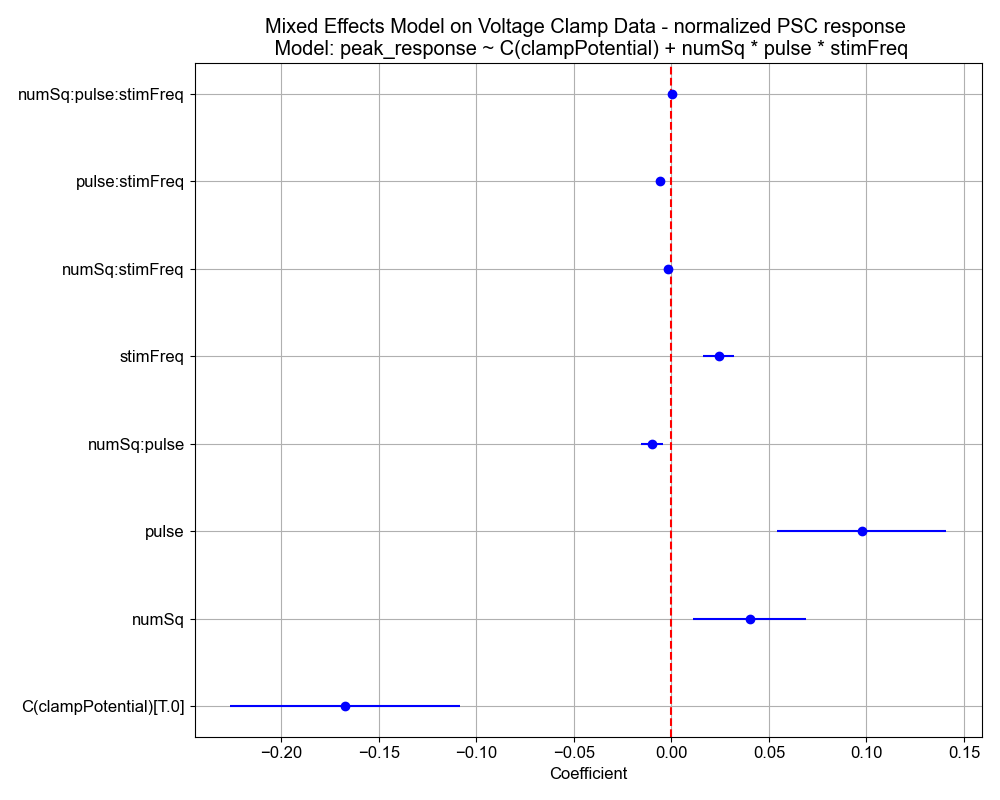

In [24]:
# Extract the fixed effects coefficients and confidence intervals
coefs = results.fe_params
conf = results.conf_int()
# remove the index 'cellID var' from conf
conf = conf.drop(['cellID Var'])
# remove intercept
coefs = coefs.drop('Intercept')
conf = conf.drop('Intercept')

# Create the plot
plt.figure(figsize=(10, 8), layout='tight')
plt.errorbar(coefs, coefs.index, xerr=(conf[1] - coefs), fmt='o', color='blue', label="Coefficients")

# Add a vertical line at zero for reference
plt.axvline(x=0, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Coefficient')
plt.title(f'Mixed Effects Model on Voltage Clamp Data - normalized PSC response \n Model: {formula}')
plt.grid(True)
plt.show()

# save fig
filename = f'Fig2s1_MEM_coefficient_plot'
plt.savefig(paper_figure_export_location / (filename + '.svg'), format='svg', dpi=300)
plt.savefig(paper_figure_export_location / (filename + '.png'), format='png', dpi=300)

### 2. Interaction plot

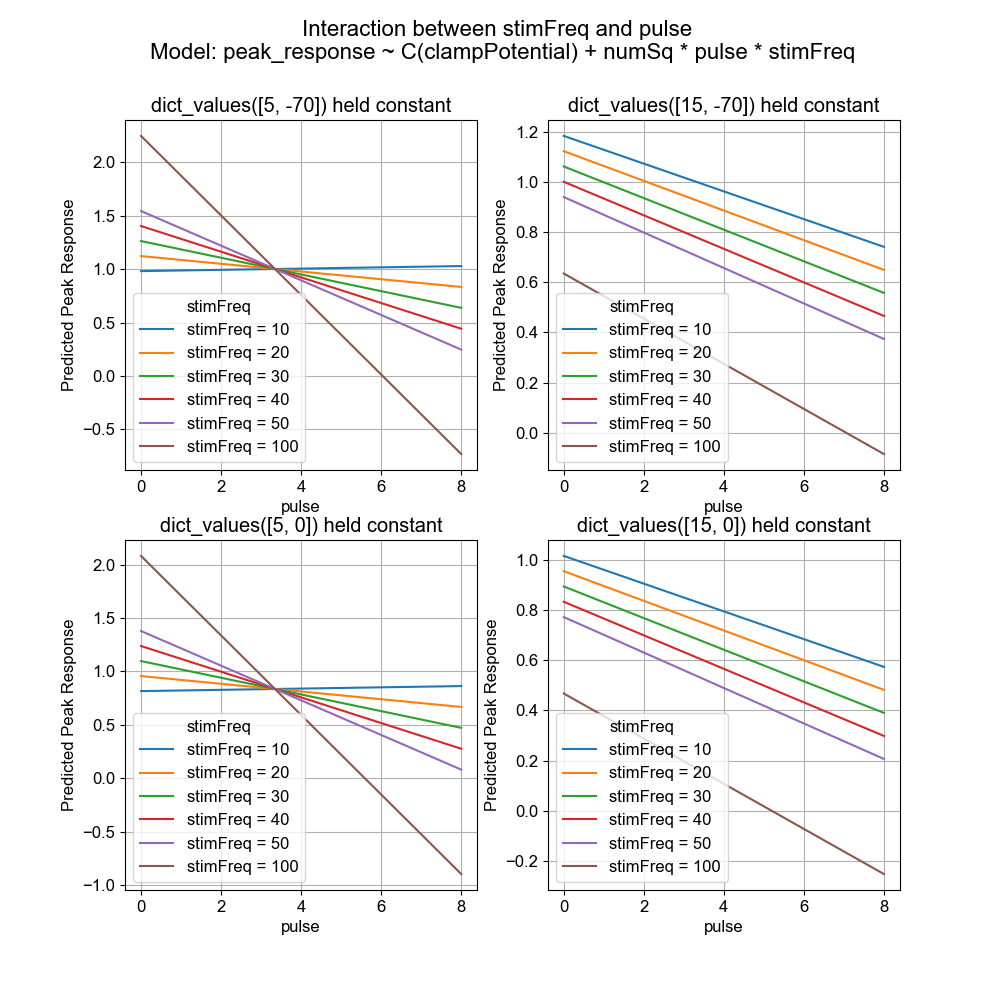

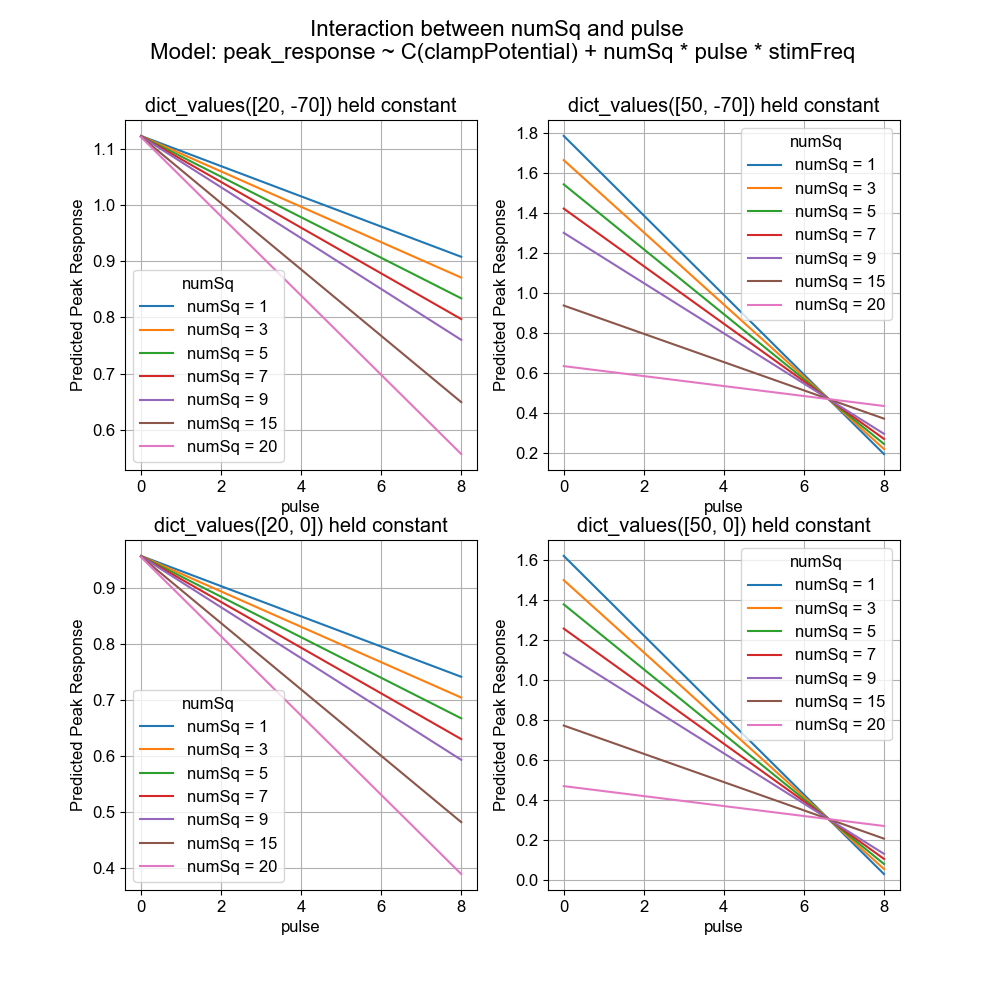

In [25]:
def plot_interaction(var1, var2, var1_values, var2_values, df, model, constant_vars, ax):
    """
    Plots the interaction effect between two variables from the mixed-effects model.

    Parameters:
    - var1: str, the name of the first variable.
    - var2: str, the name of the second variable.
    - var1_values: list, the values of var1 to be tested.
    - var2_values: list, the values of var2 to be tested.
    - df: DataFrame, the original DataFrame containing the data.
    - model: fitted mixed-effects model (results in this case).
    - constant_vars: dict, other variables held constant (e.g., median values).

    Returns:
    - A plot showing the interaction between var1 and var2.
    """

    # Create a list to hold the DataFrames for predictions
    predictions_list = []

    # Generate predictions for each combination of var1 and var2
    for val1 in var1_values:
        df_pred = pd.DataFrame({
            var1: val1,
            var2: var2_values
        })

        # Add other constant variables
        for const_var, const_value in constant_vars.items():
            df_pred[const_var] = const_value
        
        # Add a representative cellID
        df_pred['cellID'] = 2941

        # Generate predictions using the model
        df_pred['predicted_peak_response'] = model.predict(df_pred)
        predictions_list.append(df_pred)

    # Concatenate all predictions into a single DataFrame
    predictions = pd.concat(predictions_list)

    for val1 in var1_values:
        subset = predictions[predictions[var1] == val1]
        ax.plot(subset[var2], subset['predicted_peak_response'], label=f'{var1} = {val1}')

    ax.set_xlabel(var2)
    ax.set_ylabel('Predicted Peak Response')
    ax.set_title(f'{constant_vars.values()} held constant')
    ax.legend(title=var1)
    ax.grid(True)

# make a four subplot figure
fig, ax = plt.subplots(2,2, figsize=(10,10), sharex=False, sharey=False, )
# add fig title
fig.suptitle(f'Interaction between stimFreq and pulse \n Model: {formula}', fontsize=16)
ax = ax.ravel()

# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('stimFreq', 'pulse', [10, 20, 30, 40, 50, 100], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'numSq':5, 'clampPotential':-70}, ax[0])
# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('stimFreq', 'pulse', [10, 20, 30, 40, 50, 100], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'numSq':15, 'clampPotential':-70}, ax[1])
# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('stimFreq', 'pulse', [10, 20, 30, 40, 50, 100], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'numSq':5, 'clampPotential':0}, ax[2])
# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('stimFreq', 'pulse', [10, 20, 30, 40, 50, 100], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'numSq':15, 'clampPotential':0}, ax[3])

# save fig
plt.savefig(paper_figure_export_location / f'Fig2s2_MEM_interaction_plot_freq_vs_pulse.svg', format='svg', dpi=300)
plt.savefig(paper_figure_export_location / f'Fig2s2_MEM_interaction_plot_freq_vs_pulse.png', format='png', dpi=300)


# make a four subplot figure
fig2, ax2 = plt.subplots(2,2, figsize=(10,10), sharex=False, sharey=False, )
# add fig title
fig2.suptitle(f'Interaction between numSq and pulse \n Model: {formula}', fontsize=16)
ax = ax2.ravel()

# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('numSq', 'pulse', [1,3,5,7,9,15,20], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':20, 'clampPotential':-70}, ax[0])
# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('numSq', 'pulse', [1,3,5,7,9,15,20], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':50, 'clampPotential':-70}, ax[1])
# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('numSq', 'pulse', [1,3,5,7,9,15,20], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':20, 'clampPotential':0}, ax[2])
# Plot interaction between 'stimFreq' and 'pulse'
plot_interaction('numSq', 'pulse', [1,3,5,7,9,15,20], [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':50, 'clampPotential':0}, ax[3])
# save fig
plt.savefig(paper_figure_export_location / f'Fig2s3_MEM_interaction_plot_numSq_vs_pulse.svg', format='svg', dpi=300)
plt.savefig(paper_figure_export_location / f'Fig2s3_MEM_interaction_plot_numSq_vs_pulse.png', format='png', dpi=300)

### Effect Plot
An effect plot, also known as a partial dependence plot, shows how the predicted response variable (peak_response) changes as a single predictor variable changes, while holding other variables constant. This type of plot is particularly useful for understanding the marginal effect of a predictor on the response.

Example Code to Generate an Effect Plot
Let’s create an effect plot for one of your variables, say numSq, while holding the other variables constant. We can then do the same for other variables like stimFreq and pulse.

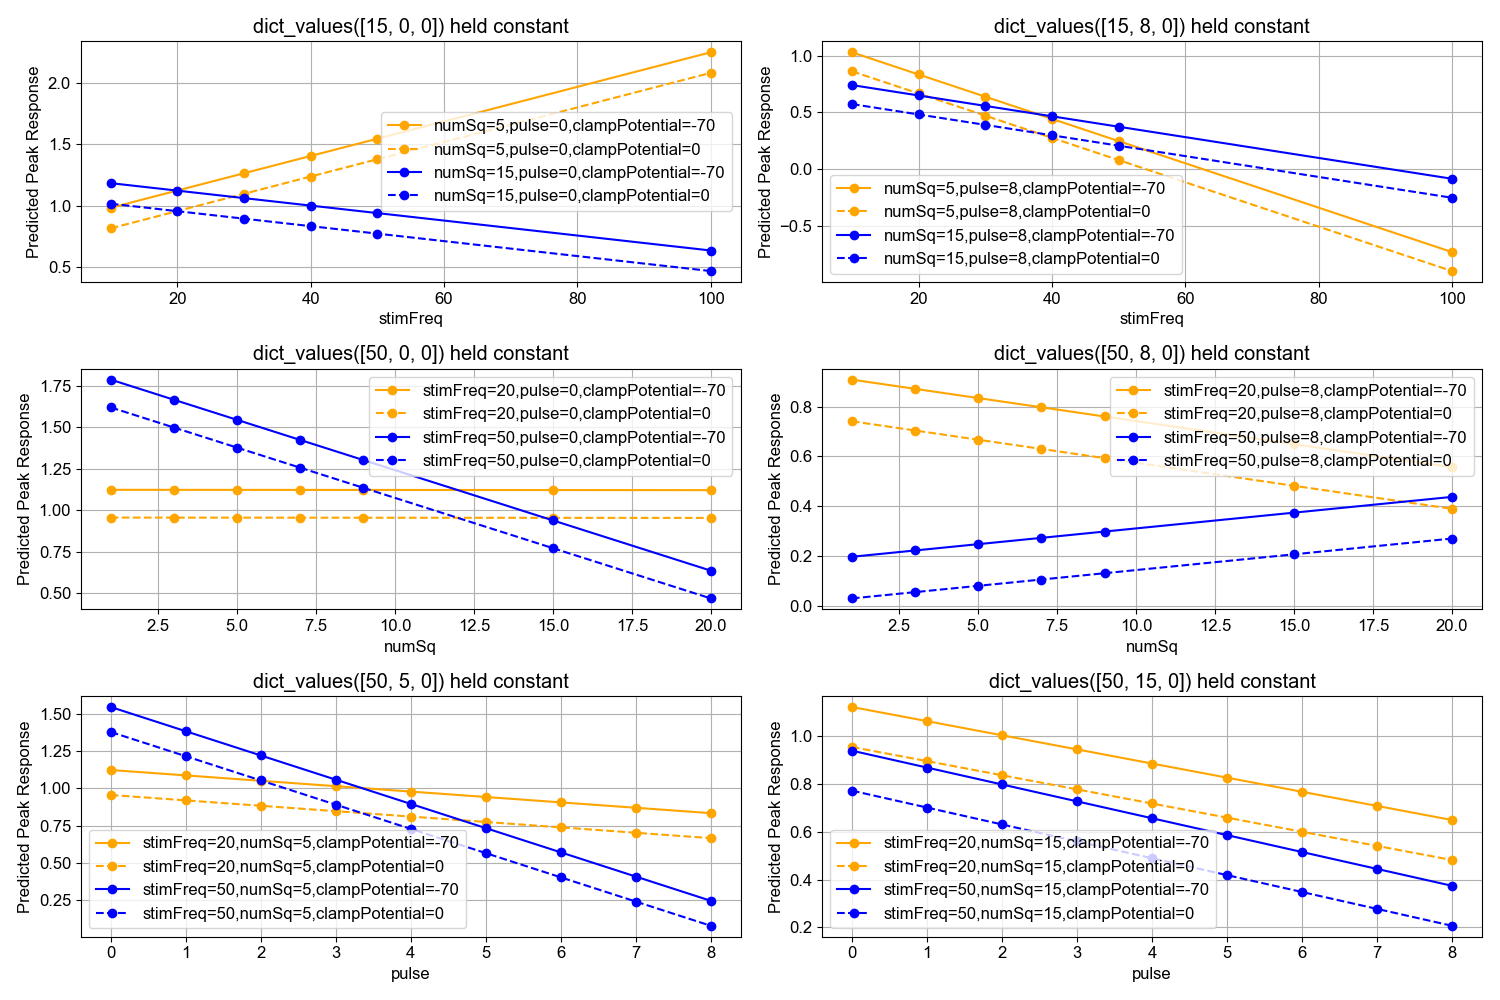

In [26]:
def plot_effect(var, var_values, df, model, constant_vars, ax, label="",lstyle='-', color='blue'):
    """
    Plots the effect of a single variable on the response variable while holding other variables constant.

    Parameters:
    - var: str, the name of the variable.
    - var_values: list, the values of var to be tested.
    - df: DataFrame, the original DataFrame containing the data.
    - model: fitted mixed-effects model (results in this case).
    - constant_vars: dict, other variables held constant (e.g., median values).

    Returns:
    - A plot showing the effect of the variable on the predicted peak response.
    """

    # Create a DataFrame to hold the predictions
    df_pred = pd.DataFrame({var: var_values})

    # Add other constant variables
    for const_var, const_value in constant_vars.items():
        df_pred[const_var] = const_value

    # Add a representative cellID
    df_pred['cellID'] = 2941

    # Generate predictions using the model
    df_pred['predicted_peak_response'] = model.predict(df_pred)
    if label == "":
        # convert dict values into a string
        label = ','.join([f'{key}={value}' for key, value in constant_vars.items()])
    # Plot the effect
    ax.plot(df_pred[var], df_pred['predicted_peak_response'], marker='o', color=color, linestyle=lstyle, label=label)
    ax.set_xlabel(var)
    ax.set_ylabel('Predicted Peak Response')
    ax.set_title(f'{constant_vars.values()} held constant')
    ax.grid(True)
    ax.legend()
    # plt.show()

fig, ax = plt.subplots(3,2, figsize=(15,10), sharex=False, sharey=False, )
ax = ax.ravel()

# Plot the effect of 'stimFreq' on the predicted peak response while varying numSq and clampPotential
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':5, 'pulse':0, 'clampPotential':-70}, ax[0], color='orange')
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':5, 'pulse':0, 'clampPotential':0}, ax[0],lstyle='--', color='orange')
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':15, 'pulse':0, 'clampPotential':-70}, ax[0],)
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':15, 'pulse':0, 'clampPotential':0}, ax[0],lstyle='--')

plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':5, 'pulse':8, 'clampPotential':-70}, ax[1], color='orange')
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':5, 'pulse':8, 'clampPotential':0}, ax[1],lstyle='--', color='orange')
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':15, 'pulse':8, 'clampPotential':-70}, ax[1],)
plot_effect('stimFreq', [10, 20, 30, 40, 50, 100], df_melt, results, {'numSq':15, 'pulse':8, 'clampPotential':0}, ax[1],lstyle='--')

# Plot the effect of 'numSq' on the predicted peak response while varying stimFreq and clampPotential
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':20, 'pulse':0, 'clampPotential':-70}, ax[2], color='orange')
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':20, 'pulse':0, 'clampPotential':0}, ax[2],lstyle='--', color='orange')
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':50, 'pulse':0, 'clampPotential':-70}, ax[2],)
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':50, 'pulse':0, 'clampPotential':0}, ax[2],lstyle='--')

plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':20, 'pulse':8, 'clampPotential':-70}, ax[3], color='orange')
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':20, 'pulse':8, 'clampPotential':0}, ax[3],lstyle='--', color='orange')
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':50, 'pulse':8, 'clampPotential':-70}, ax[3],)
plot_effect('numSq', [1,3,5,7,9,15,20], df_melt, results, {'stimFreq':50, 'pulse':8, 'clampPotential':0}, ax[3],lstyle='--')

# Plot the effect of 'pulse' on the predicted peak response while varying stimFreq and clampPotential
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':20, 'numSq':5, 'clampPotential':-70}, ax[4], color='orange')
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':20, 'numSq':5, 'clampPotential':0}, ax[4],lstyle='--', color='orange')
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':50, 'numSq':5, 'clampPotential':-70}, ax[4],)
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':50, 'numSq':5, 'clampPotential':0}, ax[4],lstyle='--')

plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':20, 'numSq':15, 'clampPotential':-70}, ax[5], color='orange')
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':20, 'numSq':15, 'clampPotential':0}, ax[5],lstyle='--', color='orange')
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':50, 'numSq':15, 'clampPotential':-70}, ax[5],)
plot_effect('pulse', [0, 1, 2, 3, 4, 5, 6, 7, 8], df_melt, results, {'stimFreq':50, 'numSq':15, 'clampPotential':0}, ax[5],lstyle='--')


# layout tight
plt.tight_layout()

# save fig
plt.savefig(paper_figure_export_location / f'Fig2s4_MEM_effect_plot_interaction.svg', format='svg', dpi=300)
plt.savefig(paper_figure_export_location / f'Fig2s4_MEM_effect_plot_interaction.png', format='png', dpi=300)

## Step 4: Marginal Effect Plot
A marginal effect plot shows how the predicted response (peak_response) changes with respect to one variable, averaging out the effects of the other variables. This type of plot is useful for understanding the general trend of a predictor across its range while accounting for the influence of other variables.

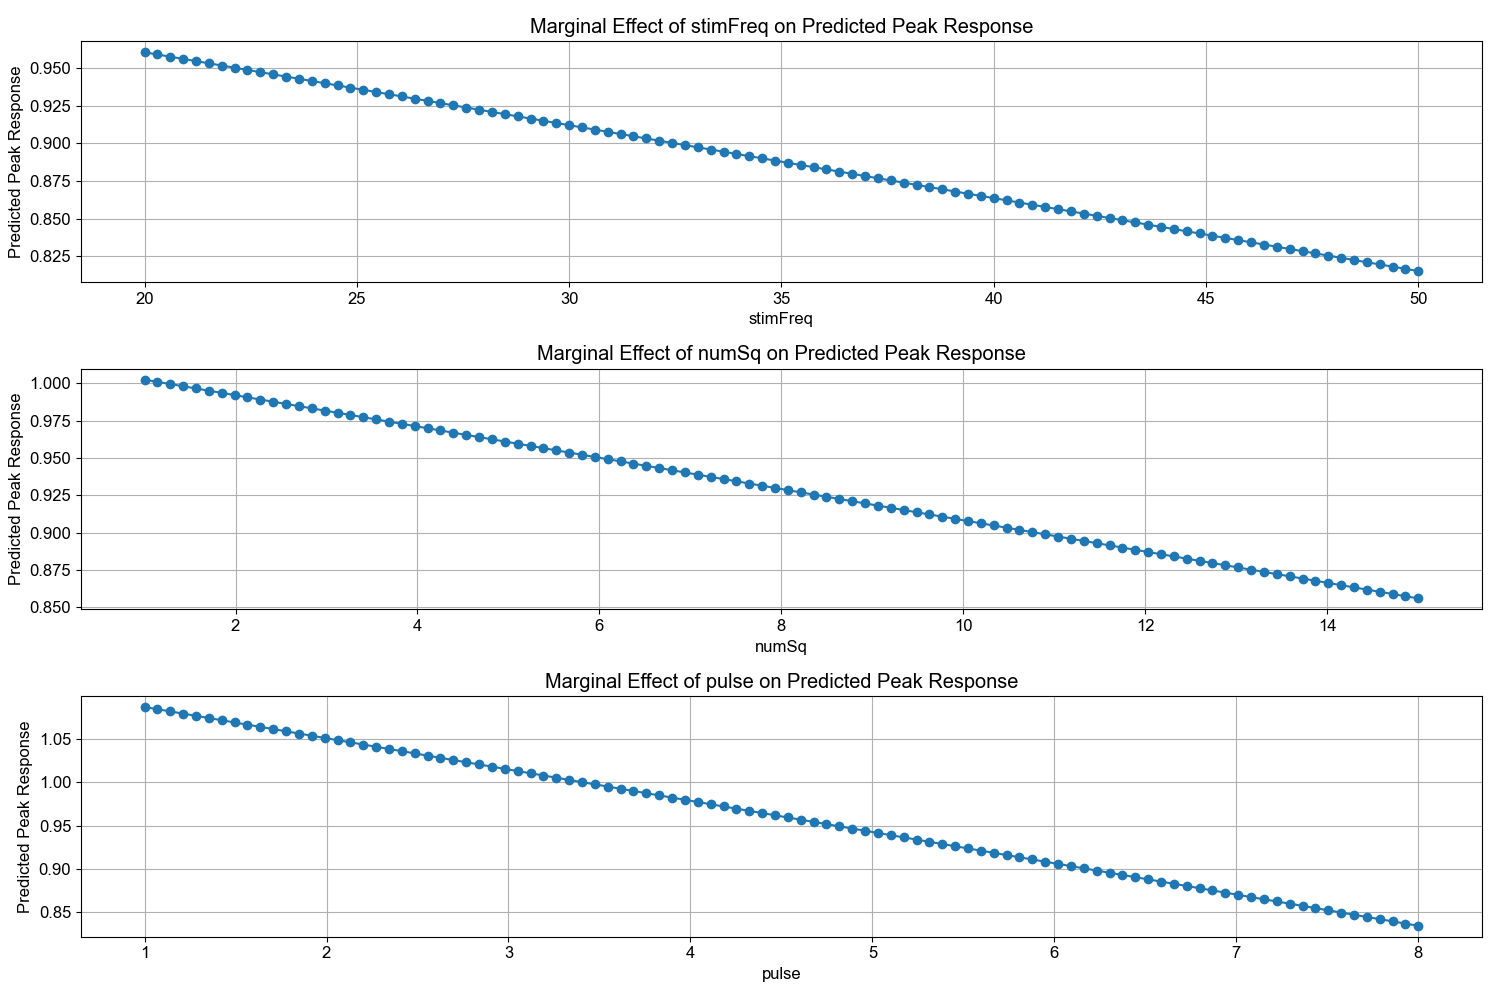

In [27]:
def plot_marginal_effect(var, df, model, ax):
    """
    Plots the marginal effect of a single variable on the response variable.

    Parameters:
    - var: str, the name of the variable.
    - df: DataFrame, the original DataFrame containing the data.
    - model: fitted mixed-effects model (results5 in this case).

    Returns:
    - A plot showing the marginal effect of the variable on the predicted peak response.
    """

    # Create a DataFrame with unique values of the variable
    var_values = np.linspace(df[var].min(), df[var].max(), 100)
    df_pred = pd.DataFrame({var: var_values})

    # For other variables, set them to the median of the data
    for other_var in df.columns:
        if other_var != var and other_var != 'peak_response' and other_var != 'cellID':
            df_pred[other_var] = df[other_var].median()

    # Add a representative cellID
    df_pred['cellID'] = df['cellID'].iloc[0]

    # Generate predictions using the model
    df_pred['predicted_peak_response'] = model.predict(df_pred)


    # Plot the marginal effect
    ax.plot(df_pred[var], df_pred['predicted_peak_response'], marker='o', linestyle='-')
    ax.set_xlabel(var)
    ax.set_ylabel('Predicted Peak Response')
    ax.set_title(f'Marginal Effect of {var} on Predicted Peak Response')
    ax.grid(True)

# plots
fig, ax = plt.subplots(3,1, figsize=(15,10), sharex=False, sharey=False, )

# Plot the marginal effect of 'stimFreq'
plot_marginal_effect('stimFreq', df_melt, results, ax[0])

# Plot the marginal effect of 'numSq'
plot_marginal_effect('numSq', df_melt, results, ax[1])

# Plot the marginal effect of 'pulse'
plot_marginal_effect('pulse', df_melt, results, ax[2])

# layout tight
plt.tight_layout()

# save fig
plt.savefig(paper_figure_export_location / f'Fig2s5_MEM_marginal_effect_plot.svg', format='svg', dpi=300)
plt.savefig(paper_figure_export_location / f'Fig2s5_MEM_marginal_effect_plot.png', format='png', dpi=300)

## 5: Predicted vs. Actual Values Plot
This plot is a key diagnostic tool to evaluate how well your model predicts the actual data. It’s a simple scatter plot where:

The x-axis represents the predicted values (peak_response) from your model.
The y-axis represents the actual observed values.
Purpose of the Plot:
Model Fit: Ideally, the points should cluster around the diagonal line (where predicted = actual). This would indicate a good fit.
Identifying Errors: Deviations from the diagonal can highlight areas where the model may not be fitting the data well.

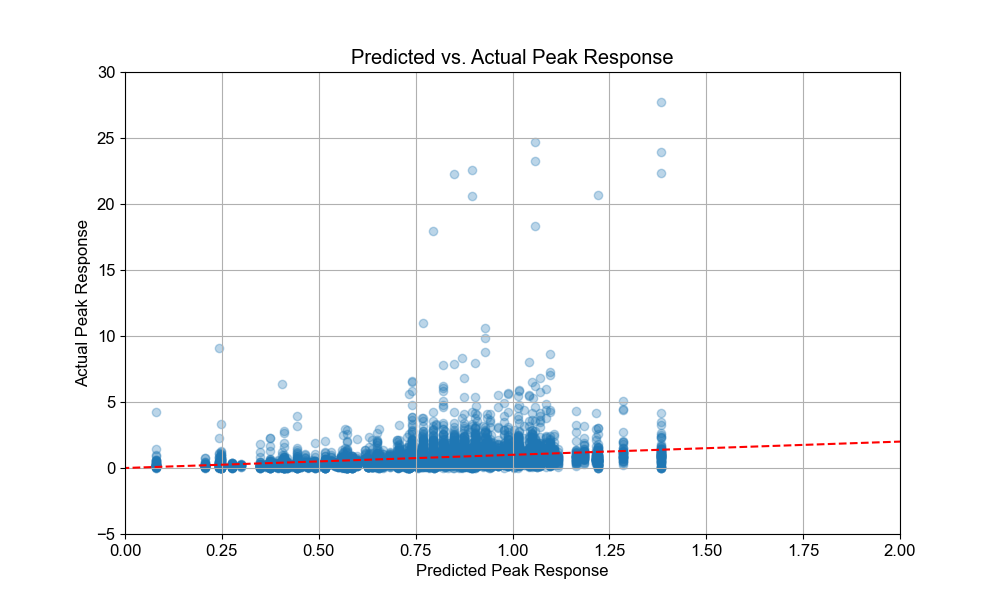

In [28]:
def plot_predicted_vs_actual(df, model):
    """
    Plots predicted vs. actual values for the response variable.

    Parameters:
    - df: DataFrame, the original DataFrame containing the data.
    - model: fitted mixed-effects model (results5 in this case).

    Returns:
    - A scatter plot showing predicted vs. actual values.
    """

    # Generate predicted values using the model
    df['predicted_peak_response'] = model.predict(df)

    # Plot the predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(df['predicted_peak_response'], df['peak_response'], alpha=0.3)
    plt.plot([df['peak_response'].min(), df['peak_response'].max()],
             [df['peak_response'].min(), df['peak_response'].max()],
             color='red', linestyle='--')
    plt.xlabel('Predicted Peak Response')
    plt.ylabel('Actual Peak Response')
    plt.xlim([0,2])
    plt.ylim([-5,30])
    plt.title('Predicted vs. Actual Peak Response')
    plt.grid(True)
    plt.show()
    # save fig
    plt.savefig(paper_figure_export_location / f'Fig2s6_MEM_predicted_vs_actual.svg', format='svg', dpi=300)
    plt.savefig(paper_figure_export_location / f'Fig2s6_MEM_predicted_vs_actual.png', format='png', dpi=300)

# Example Usage:
plot_predicted_vs_actual(df_melt, results)

# SVM

In [29]:
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='VC')]

dftemp['numSq'].astype(int)
dftemp['clampPotential'].astype(int)
dftemp['stimFreq'].astype(int)
dftemp['patternList'].apply(lambda x: int(x))

feature = 'PSC'

idvars=['cellID','clampPotential','stimFreq','numSq','patternList']
to_plot = [f'{feature}_{i}' for i in range(9)]
df_melt = pd.melt( dftemp, id_vars=idvars, value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
if not 'pulse' in dftemp.columns:
    df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
    df_melt['pulse'] = df_melt['pulse'].astype(int)
    df_melt.drop(columns=['pulseIndex'], inplace=True)

In [33]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
# import gridsearchcv
from sklearn.model_selection import GridSearchCV
# 3 import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

Q1 = df_melt['peak_response'].quantile(0.25)
Q3 = df_melt['peak_response'].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers in peak_response
df_filtered = df_melt[~((df_melt['peak_response'] < (Q1 - 1.5 * IQR)) | (df_melt['peak_response'] > (Q3 + 1.5 * IQR)))]


# Step 1: Aggregate the replicates by averaging, excluding 'patternList'
df_aggregated = df_filtered.groupby(['cellID', 'numSq', 'stimFreq', 'clampPotential', 'pulse','patternList']).mean().reset_index()

# Assuming df is your pandas DataFrame
numerical_columns = ['numSq', 'stimFreq', 'pulse']
# Initialize the scaler
scaler = StandardScaler()
# Fit the scaler on the numerical columns and transform them
df_aggregated[numerical_columns] = scaler.fit_transform(df_aggregated[numerical_columns])

# Step 2: One-Hot Encode the 'cellID' and 'clampPotential' variables
encoder_cellID = OneHotEncoder(sparse_output=False)
cellID_encoded = encoder_cellID.fit_transform(df_aggregated[['cellID']])

encoder_clampPotential = OneHotEncoder(sparse_output=False)
clampPotential_encoded = encoder_clampPotential.fit_transform(df_aggregated[['clampPotential']])

# Combine the encoded 'cellID', 'clampPotential' with the rest of the features
X_basic = df_aggregated[['numSq', 'stimFreq', 'pulse']].values
X_with_categorical = np.hstack([X_basic, cellID_encoded, clampPotential_encoded])

# Step 3: Create interaction terms using PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X_with_categorical)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_interactions, df_aggregated['peak_response'], test_size=0.2, random_state=42)
# shapes of each
'''
X_train: (n_samples, n_features)
X_test: (n_samples, n_features)
y_train: (n_samples,)
y_test: (n_samples,)
'''

# Step 5: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning
param_grid = {
    'C': [50, 100, 200],
    'epsilon': [0.01, 0.05, 0.1],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

print("Best parameters from extended Grid Search:", grid_search.best_params_)
C, ep = grid_search.best_params_['C'], grid_search.best_params_['epsilon']
ker = grid_search.best_params_['kernel']
# Step 6: Initialize the SVR model with the best parameters from the previous grid search
svr = SVR(kernel=ker, C=C, epsilon=ep)

# Step 7: Fit the SVR model
svr.fit(X_train_scaled, y_train)

# Step 8: Make predictions and evaluate the model
y_pred = svr.predict(X_test_scaled) # shape (n_samples,)

print("MSE with Updated Model:", mean_squared_error(y_test, y_pred), '\n')
print("R² Score with Updated Model:", r2_score(y_test, y_pred), '\n')

crossval_scores = cross_val_score(svr, X_train_scaled, y_train, cv=20, scoring='r2')
print("Cross-validated R² crossval_scores:", crossval_scores, '\n')
print("Mean Cross-validated R²:", np.mean(crossval_scores), '\n')
print("Standard Deviation of Cross-validated R²:", np.std(crossval_scores), '\n')

# MAE: Mean Absolute Error
'''
Mean Absolute Error (MAE) is the average of the absolute differences between predictions and actual values.
'''
mae = mean_absolute_error(y_test, y_pred,)
print("Mean Absolute Error (MAE):", mae, '\n')

Best parameters from extended Grid Search: {'C': 100, 'degree': 2, 'epsilon': 0.1, 'kernel': 'rbf'}
MSE with Updated Model: 251.4766522953097 

R² Score with Updated Model: 0.9156413439898593 

Cross-validated R² crossval_scores: [0.91649841 0.92216688 0.8895649  0.90543934 0.92634495 0.91138007
 0.90695761 0.92798693 0.87828836 0.92027862 0.92002409 0.94464998
 0.92025311 0.94672643 0.93304941 0.93590563 0.92522907 0.92994477
 0.91444745 0.92208931] 

Mean Cross-validated R²: 0.9198612660255652 

Standard Deviation of Cross-validated R²: 0.016046770255810264 

Mean Absolute Error (MAE): 10.159304536892526 



### SVM Plots

Feature Importance:
SVR models do not inherently provide feature importance, but you can estimate it by looking at the effect of feature scaling on the model’s performance.

Alternatively, you can use model-agnostic methods like permutation importance or SHAP values to evaluate which features have the biggest influence on the predictions.

Here’s an example using permutation importance:

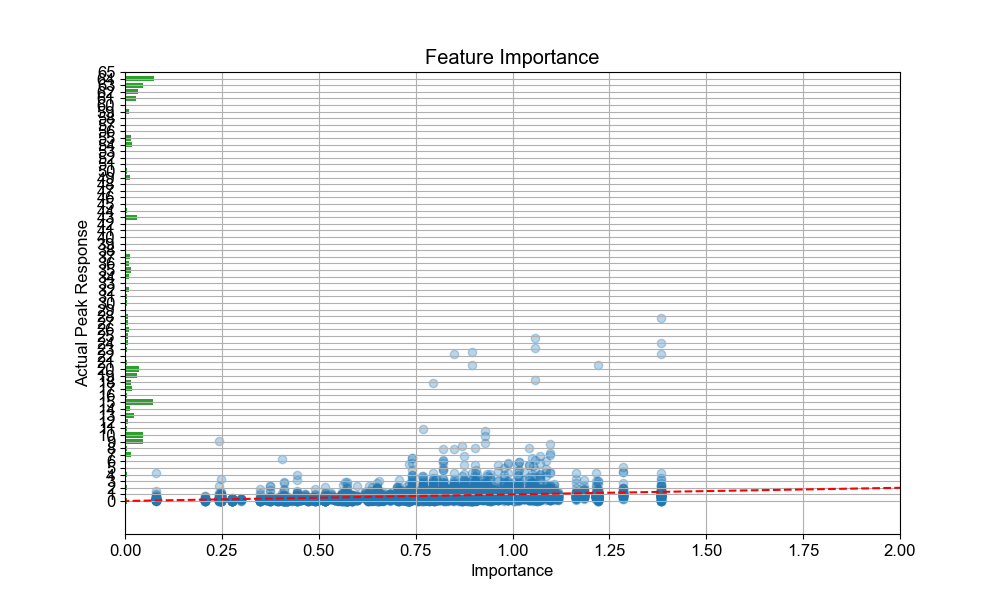

In [35]:
from sklearn.inspection import permutation_importance

# Perform permutation importance on the trained SVR model
importance = permutation_importance(svr, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Plot the importance
plt.barh(range(len(importance.importances_mean)), importance.importances_mean)
# plt.yticks(range(len(importance.importances_mean)), ['numSq', 'stimFreq', 'pulse', 'cellID_enc', 'clampPotential_enc'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


### Summary of Key Visualizations:
* Predicted vs Actual Plot: To compare predicted vs actual values.
* Residuals Plot & Histogram: To check for systematic bias.
* Feature Importance: Visualize key drivers of predictions.
* Cross-validation Results: To check stability across folds.
* 3D Plot & Partial Dependence Plot: For feature interactions.
* Learning Curves: To understand model generalization and need for more data.
* Heatmap: To show correlations among features.

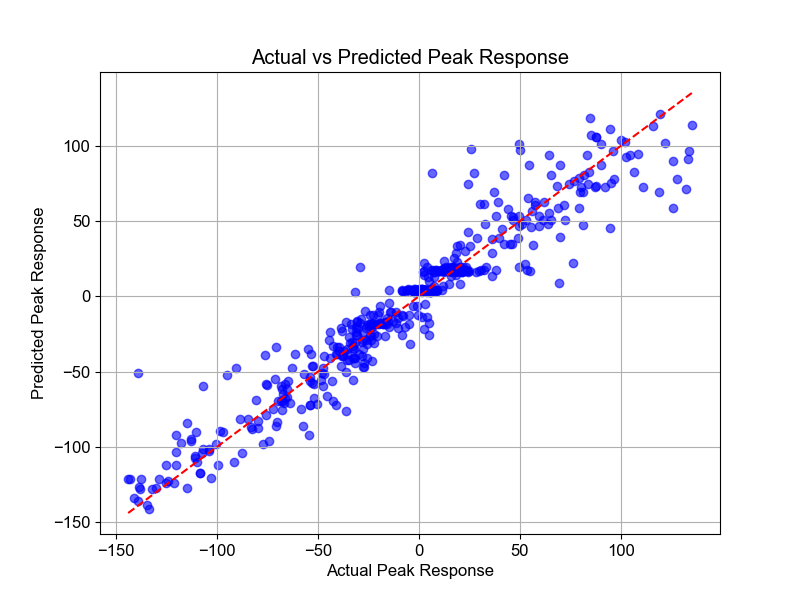

In [225]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Peak Response')
plt.ylabel('Predicted Peak Response')
plt.title('Actual vs Predicted Peak Response')
plt.grid(True)
plt.show()


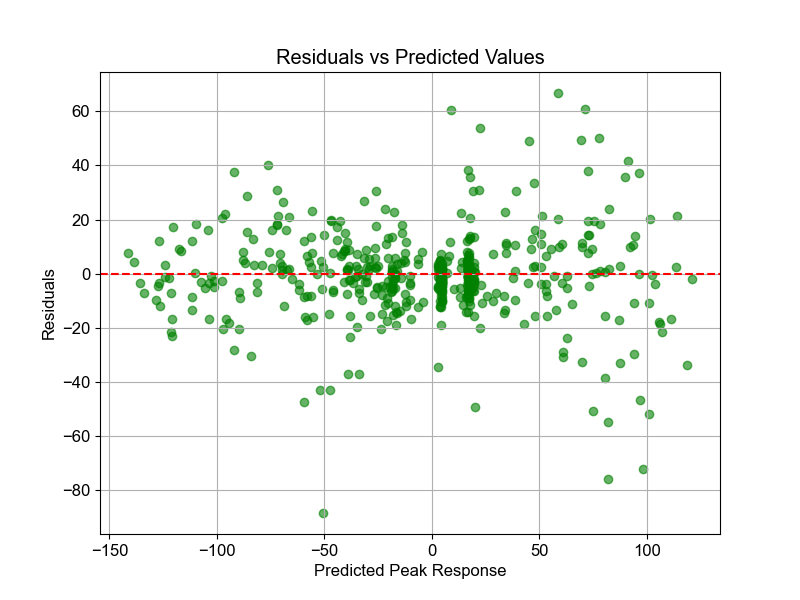

In [226]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='green', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Peak Response')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()


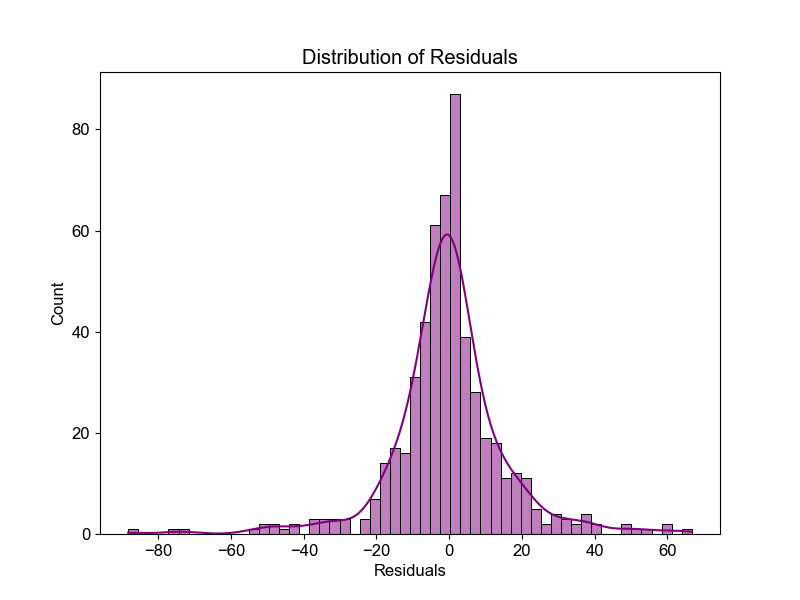

In [227]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()


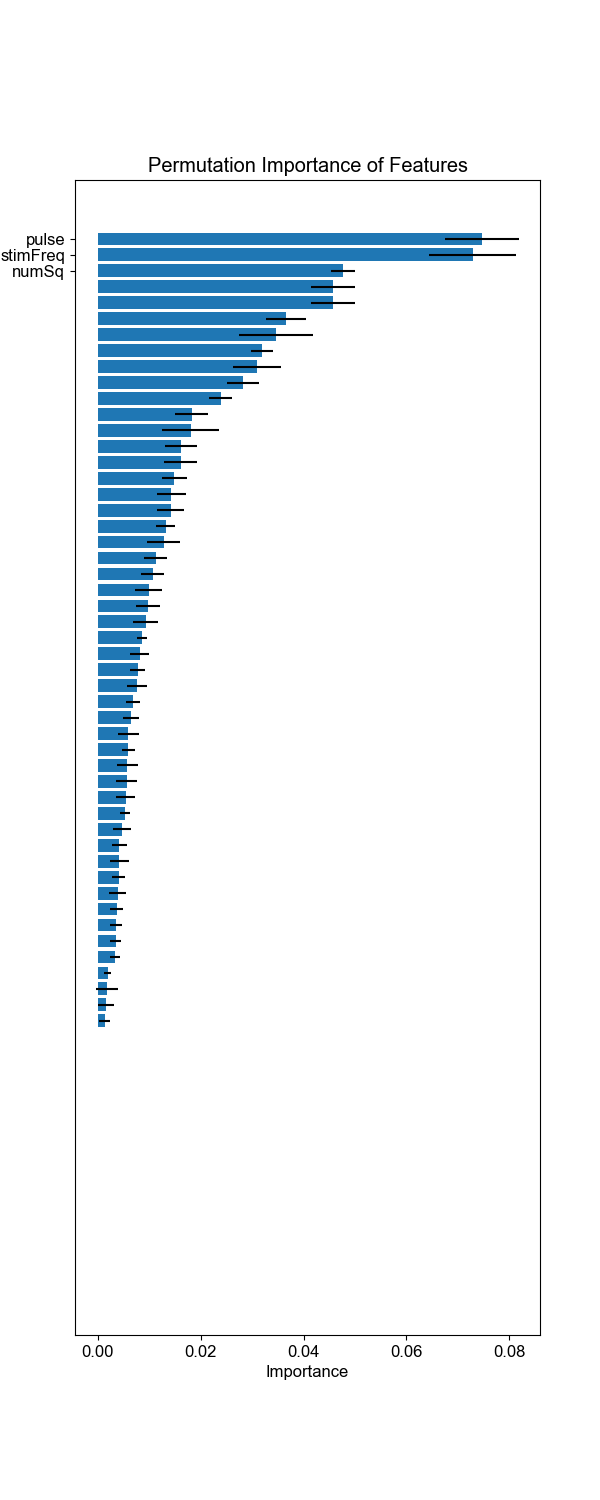

In [240]:
from sklearn.inspection import permutation_importance

result = permutation_importance(svr, X_test_scaled, y_test, n_repeats=10, random_state=42)
numerical_columns = ['numSq', 'stimFreq', 'pulse']
order = range(len(sorted_idx))
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(6, 15))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx])
plt.yticks(order[-len(numerical_columns):], [i for i in numerical_columns])
plt.title('Permutation Importance of Features')
plt.xlabel('Importance')
plt.show()


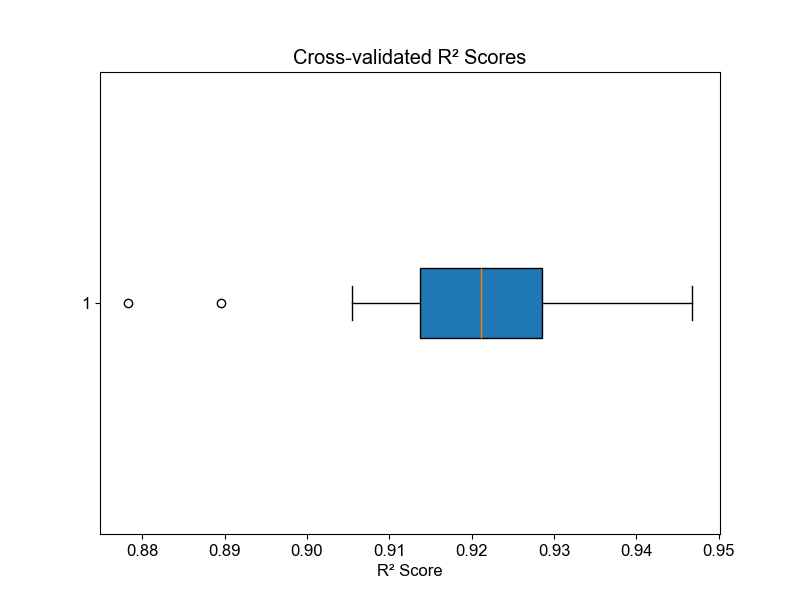

In [242]:
plt.figure(figsize=(8, 6))
plt.boxplot(crossval_scores, vert=False, patch_artist=True)
plt.title('Cross-validated R² Scores')
plt.xlabel('R² Score')
plt.show()

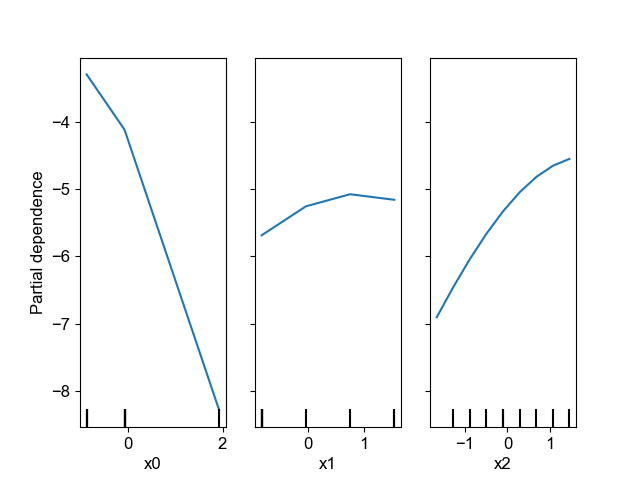

In [267]:
from sklearn.inspection import PartialDependenceDisplay

features = [0, 1, 2]  # Assuming 'numSq' and 'stimFreq' are the first two features
PartialDependenceDisplay.from_estimator(svr, X_train_scaled, features, grid_resolution=50)
plt.show()


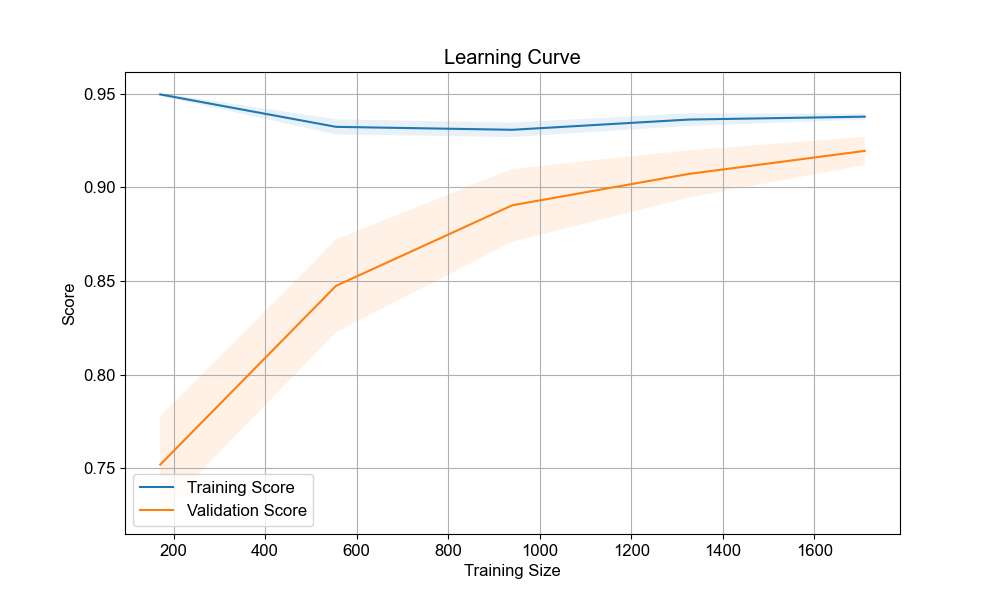

In [268]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(svr, X_train_scaled, y_train, cv=5)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1)
plt.fill_between(train_sizes, np.mean(test_scores, axis=1) - np.std(test_scores, axis=1),
                 np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), alpha=0.1)
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


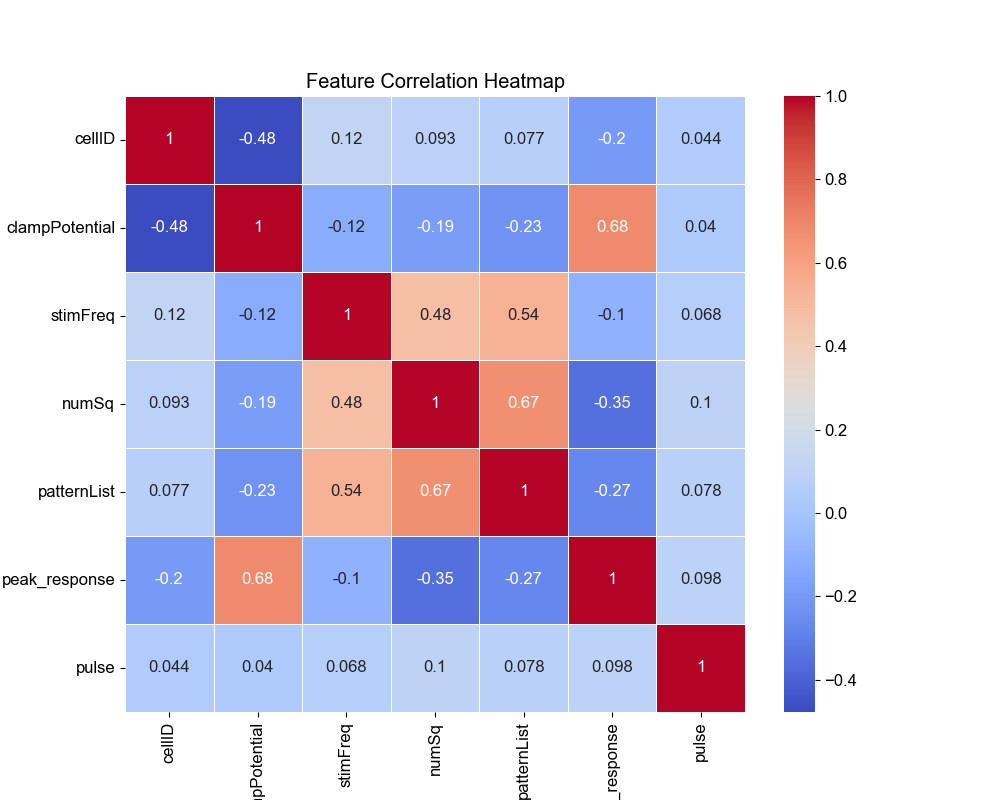

In [270]:
corr = df_filtered.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()
